In [172]:
import pandas as pd
import numpy as np
import sys
from matplotlib import pyplot as plt

import tensorflow as tf
from gensim.models import Word2Vec

In [173]:
class TF_Agent():
    
    def __init__(self, keys):
        self._initialize(keys)
        
    def _initialize(self, keys):
        np.random.seed(1050554145)
        self.log_df = pd.DataFrame({key: [] for key in keys})
        self.keys = self.log_df.columns
        self.interesting = ",".join(self.log_df.columns)
        self.iter_count = 0     

    def set_batch(self, n, feed_dict):

        keys = list(feed_dict.keys())
        
        data_n = len(feed_dict[keys[0]])
        idxs = np.random.choice(range(data_n), n, replace=False)
        
        feed_dict = {key: feed_dict[key][idxs] for key in keys}
        self.feed_dict = feed_dict
    
    def run_session(self, sess):
        
        values = sess.run(eval(self.interesting),
                          feed_dict=self.feed_dict)
        
        self.recent_log = pd.Series(
            values,
            index=self.keys,
            name=self.iter_count
        )
        self.log_df = self.log_df.append([self.recent_log])
        
        self.iter_count += 1
        
    def trace(self, args):
        
        one_line_text=""
        iter_count = self.iter_count
        
        one_line_text = "Iter: % 6d"%iter_count
        for arg in args:
            one_line_text += " | %s: %0.9f"%(
                arg, self.recent_log[arg]
            )

        sys.stdout.write("\r%s"%one_line_text)

In [174]:
underscore_train_X = pd.read_pickle("./data/underscore_tr_X")
underscore_test_X = pd.read_pickle("./data/underscore_te_X")

train_y = pd.read_pickle("./data/tr_y")
test_y = pd.read_pickle("./data/te_y")

In [161]:
rnn_size, batch_n, iter_n = 128, 128, 2048
train_X = underscore_train_X
test_X = underscore_test_X
squence_size = 160

tf.reset_default_graph()
g = tf.get_default_graph()
tf.set_random_seed(1050554145)

X = tf.placeholder(dtype=tf.float32,
                   shape=[None, squence_size, 128])
y = tf.placeholder(dtype=tf.float32,
                   shape=[None, 2])

lstm_cell = tf.nn.rnn_cell.BasicLSTMCell(num_units=rnn_size)
outputs, state = tf.nn.dynamic_rnn(lstm_cell, X, dtype=tf.float32)
logits = state[1]

weight = tf.Variable(tf.truncated_normal([rnn_size, 2]))
bias = tf.Variable(tf.truncated_normal([2]))

fc = tf.matmul(logits, weight) + bias
acc = tf.reduce_mean(
    tf.cast(
        tf.equal(tf.argmax(fc, axis=1), tf.argmax(y, axis=1)),
        dtype=tf.float32
    )
)
loss = tf.losses.softmax_cross_entropy(y, fc)
learn = tf.train.AdamOptimizer().minimize(loss)

initializer = tf.global_variables_initializer()


sess = tf.Session(graph=g)
sess.run(initializer)

tfa = TF_Agent(["loss", "acc", "learn"])
for _ in range(iter_n):
    tfa.set_batch(batch_n, {X: train_X, y: train_y})
    tfa.run_session(sess)
    tfa.trace(["loss", "acc"])

print()
pred = sess.run(acc, feed_dict={X: test_X, y: test_y})
print("test accuracy:", pred)
pred = sess.run(acc, feed_dict={X: train_X, y: train_y})
print("train accuracy:", pred)

saver = tf.train.Saver()
saver.save(sess, "./sess.ckpt")

sess.close()

Iter:   2048 | loss: 0.132466853 | acc: 0.968750000
test accuracy: 0.78396
train accuracy: 0.92928


In [256]:
def attack(i, sentence):
    
    def get_victim(i):
        victim = sentence.copy()
        victim[i] = A
        return victim
    
    if case == 1:
        A = model.wv["_"]
        victims = [get_victim(i) for i in range(len(sentence))]
        losses = np.array([sess.run(
            loss, feed_dict={X: [victim], y: [train_y[i]]}
        ) for i, victim in enumerate(victims)])
        idx = (-np.abs(losses-recent_loss)).argmax()
        victim = victims[idx]
    elif case == 2:
        victim = sentence.copy()
        idx = np.random.choice(
            np.where(underscore_train_X[20]
                     .sum(axis=1)
                     != 0)[0]            
        )
        victim[idx] = np.random.random(128)
    
    sys.stdout.write("\rattack %03d |"%i)
    return victim


seed = 3
iter_n = 128

for case in [1, 2]:

    np.random.seed(seed)

    sess = tf.Session()
    saver.restore(sess, "./sess.ckpt")
    
    recent_loss = sess.run(loss, feed_dict={X: train_X, y: train_y})
    model = Word2Vec.load("./data/underscore_model")

    victims = np.array([attack(i, sentence) 
                        for i, sentence in enumerate(train_X)])

    for i in range(iter_n):
        idxs = np.random.choice(len(train_X), batch_n, replace=False)
        sess.run(learn, feed_dict={X: victims[idxs], y: train_y[idxs]})
        sys.stdout.write("\rAugmentation %03d |"%i)

    print()
    pred = sess.run(acc, feed_dict={X: test_X, y: test_y})
    print("test accuracy:", pred)
    pred = sess.run(acc, feed_dict={X: train_X, y: train_y})
    print("train accuracy:", pred)

    sess.close()

INFO:tensorflow:Restoring parameters from ./sess.ckpt
attack 007 |

KeyboardInterrupt: 

# Normal vs Underscore

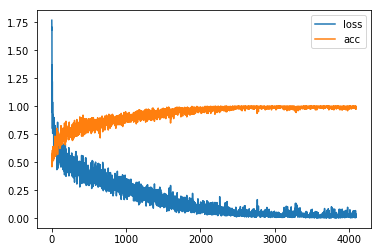

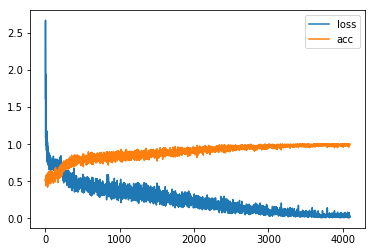

In [26]:
for case in cases:
    log_df = tfadic[case].log_df
    plt.plot(log_df["loss"].tolist())
    plt.plot(log_df["acc"].tolist())
    plt.legend(["loss", "acc"])
    plt.show()

In [ ]:
def remove_one_word(self, sentence):
    
    sess, X = self.sess, self.X
    rescent_loss = self.rescent_loss

    def attack(i):
        victim = sentence.copy()
        victim[i] = "_"
        return victim
    
    victims = [attack(i) for i in range(len(sentence))]
    losses = np.array([sess.run(loss, feed_dict={X: [v]}) for v in victims])
    losses = -abs(losses-rescent_loss)
    
    return victims[losses.argmax()]    

In [106]:
rnn_size = 128
batch_n = 128
iter_n = 4096
cases = ["normal", "underscore"]
tfadic = {case: TF_Agent(["loss", "learn", "acc"])
          for case in cases}

for case in cases:
        
    if case == "normal":
        train_X = normal_trian_X
        test_X = normal_test_X
        squence_size = 80
    elif case == "underscore":
        train_X = underscore_trian_X
        test_X = underscore_test_X
        squence_size = 160
    
    tf.reset_default_graph()
    g = tf.get_default_graph()
    tf.set_random_seed(1050554145)

    X = tf.placeholder(dtype=tf.float32,
                       shape=[None, squence_size, 128])
    y = tf.placeholder(dtype=tf.float32,
                       shape=[None, 2])
    
    lstm_cell = tf.nn.rnn_cell.BasicLSTMCell(num_units=rnn_size)
    outputs, state = tf.nn.dynamic_rnn(lstm_cell, X, dtype=tf.float32)
    logits = state[1]

    weight = tf.Variable(tf.truncated_normal([rnn_size, 2]))
    bias = tf.Variable(tf.truncated_normal([2]))

    fc = tf.matmul(logits, weight) + bias
    acc = tf.reduce_mean(
        tf.cast(
            tf.equal(tf.argmax(fc, axis=1), tf.argmax(y, axis=1)),
            dtype=tf.float32
        )
    )
    loss = tf.losses.softmax_cross_entropy(y, fc)    
    learn = tf.train.AdamOptimizer().minimize(loss)

    initializer = tf.global_variables_initializer()
    
    
    sess = tf.Session(graph=g)
    sess.run(initializer)

    tfa = tfadic[case]
    for _ in range(iter_n):
        tfa.set_batch(batch_n,
                      {X: train_X, y: train_y})
        tfa.run_session(sess)
        tfa.trace(["loss", "acc"])
    print()
    
    pred = sess.run(acc, feed_dict={X: test_X, y: test_y})
    print("test accuracy:", pred)
    pred = sess.run(acc, feed_dict={X: train_X, y: train_y})
    print("train accuracy:", pred)